- 因子分析


In [ ]:
import pandas as pd
from factor_analyzer import FactorAnalyzer
import matplotlib.pyplot as plt
from openpyxl import load_workbook


In [ ]:
# 读取文件
excel_file = pd.ExcelFile('二手汽车信息.xlsx')

# 获取指定工作表中的数据
df = excel_file.parse('原始数据')
# 这里先注释掉，实际使用时请根据你的数据读取和筛选逻辑来设置该变量
variables = df.drop(['品牌', '城市地区', '城市发展水平', '燃料类型', '车辆级别', '车身颜色', '驱动方式', '续航方式'], axis=1)


In [ ]:
fa = FactorAnalyzer(rotation=None)
fa.fit(variables)
ev, v = fa.get_eigenvalues()


/opt/anaconda3/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


In [ ]:
# 选择特征值>1的因子数（Kaiser准则）
n_factors = sum(ev > 1)
fa = FactorAnalyzer(n_factors=n_factors, rotation='varimax')


In [ ]:
print(variables.info())
print(variables.head())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11833 entries, 0 to 11832
Data columns (total 20 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   表显里程（万公里）   11833 non-null  float64
 1   排量（L）       11833 non-null  float64
 2   过户次数        11833 non-null  int64  
 3   标准容量（kwh）   11833 non-null  int64  
 4   标准快充（h）     11833 non-null  float64
 5   标准慢充（h）     11833 non-null  float64
 6   纯电续航里程（km）  11833 non-null  int64  
 7   发动机马力       11833 non-null  int64  
 8   发布时距保险到期时间  11833 non-null  int64  
 9   发布时距年检到期时间  11833 non-null  int64  
 10  发布时距上牌时间    11833 non-null  int64  
 11  Factor 1    11833 non-null  float64
 12  Factor 2    11833 non-null  float64
 13  Factor 3    11833 non-null  float64
 14  Factor 4    11833 non-null  float64
 15  Factor 1.1  11833 non-null  float64
 16  Factor 2.1  11833 non-null  float64
 17  Factor 3.1  11833 non-null  float64
 18  Factor 4.1  11833 non-null  float64
 19  Factor 5    11833 non-nul

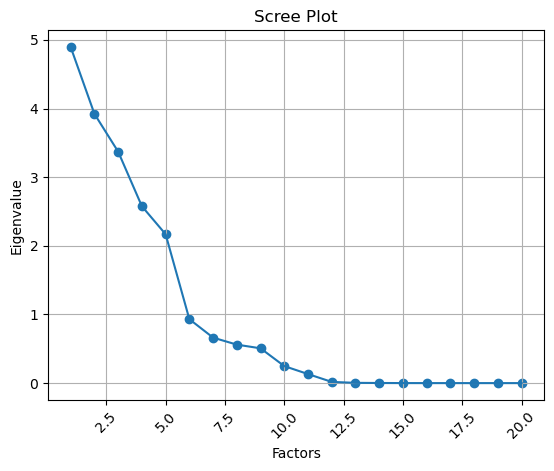

In [ ]:
# 可视化特征值，帮助确定合适的公因子数量
plt.scatter(range(1, variables.shape[1] + 1), ev)
plt.plot(range(1, variables.shape[1] + 1), ev)
plt.title('Scree Plot')
plt.xlabel('Factors')
plt.xticks(rotation=45)
plt.ylabel('Eigenvalue')
plt.grid()
plt.show()


In [ ]:
# 根据特征值大于 1 的原则确定公因子数量
num_factors = sum(ev > 1)

# 重新进行因子分析，设置确定好的公因子数量
fa = FactorAnalyzer(n_factors=num_factors, rotation='varimax')
fa.fit(variables)


/opt/anaconda3/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


FactorAnalyzer(n_factors=5, rotation='varimax', rotation_kwargs={})

In [ ]:

# 获取因子载荷矩阵，展示变量与公因子之间的关系
loadings = fa.loadings_
loadings_df = pd.DataFrame(loadings, index=variables.columns, 
                           columns=[f'Factor {i+1}' for i in range(num_factors)])
print('因子载荷矩阵：')
print(loadings_df)


因子载荷矩阵：
            Factor 1  Factor 2  Factor 3  Factor 4  Factor 5
表显里程（万公里）  -0.045703  0.029053  0.631764  0.000584 -0.015470
排量（L）       0.026926 -0.847922 -0.086589 -0.117444 -0.000411
过户次数        0.047294 -0.056595  0.236810  0.051034 -0.013688
标准容量（kwh）  -0.102042  0.465121 -0.127629  0.776063  0.020918
标准快充（h）     0.989500  0.071011  0.133423  0.086489  0.012398
标准慢充（h）    -0.692162  0.274733 -0.030738  0.312056  0.026831
纯电续航里程（km） -0.112697  0.827260 -0.230515  0.459992  0.009416
发动机马力      -0.096101  0.097009  0.051043  0.950906  0.013844
发布时距保险到期时间 -0.005590 -0.020805 -0.140066  0.031162  0.507002
发布时距年检到期时间 -0.021597  0.030601  0.014705 -0.006095  0.898179
发布时距上牌时间    0.024834  0.000732  0.981787 -0.129494 -0.093439
Factor 1   -0.026593  0.071191  0.060983  0.984982  0.039391
Factor 2    0.019050  1.002088 -0.050532  0.047843 -0.032219
Factor 3   -0.033675  0.054601  0.979434 -0.081977 -0.135010
Factor 4    1.002522 -0.013308  0.046198  0.033694  0.019420
Factor 1.1  0.50

In [ ]:
# 设置载荷阈值（可根据实际情况调整）
threshold = 0.5

# 初始化结果字典
factor_variables = {}

# 遍历每个因子列
for factor in loadings_df.columns:
    # 筛选载荷绝对值大于阈值的变量
    significant_vars = loadings_df.index[abs(loadings_df[factor]) > threshold].tolist()
    factor_variables[factor] = significant_vars

# 输出结果
print("\n每个因子对应的主要变量（载荷绝对值>{}）：".format(threshold))
for factor, vars in factor_variables.items():
    print(f"\n{factor}:")
    for var in vars:
        # 附带载荷值（可选）
        load = loadings_df.loc[var, factor]
        print(f"- {var}（载荷：{load:.3f}）")



每个因子对应的主要变量（载荷绝对值>0.5）：

Factor 1:
- 标准快充（h）（载荷：0.989）
- 标准慢充（h）（载荷：-0.692）
- Factor 4（载荷：1.003）
- Factor 1.1（载荷：0.502）
- Factor 4.1（载荷：0.981）

Factor 2:
- 排量（L）（载荷：-0.848）
- 纯电续航里程（km）（载荷：0.827）
- Factor 2（载荷：1.002）
- Factor 2.1（载荷：1.002）

Factor 3:
- 表显里程（万公里）（载荷：0.632）
- 发布时距上牌时间（载荷：0.982）
- Factor 3（载荷：0.979）
- Factor 3.1（载荷：0.962）

Factor 4:
- 标准容量（kwh）（载荷：0.776）
- 发动机马力（载荷：0.951）
- Factor 1（载荷：0.985）
- Factor 1.1（载荷：0.630）

Factor 5:
- 发布时距保险到期时间（载荷：0.507）
- 发布时距年检到期时间（载荷：0.898）
- Factor 5（载荷：1.026）


In [ ]:
# 获取方差贡献率
variance = fa.get_factor_variance()
variance_df = pd.DataFrame(variance, 
                           index=['方差贡献率', '累计方差贡献率', '特征值'], 
                           columns=[f'Factor {i+1}' for i in range(num_factors)])
print('方差贡献率：')
print(variance_df)


方差贡献率：
         Factor 1  Factor 2  Factor 3  Factor 4  Factor 5
方差贡献率    3.763471  3.754050  3.433980  3.247760  2.151954
累计方差贡献率  0.188174  0.187703  0.171699  0.162388  0.107598
特征值      0.188174  0.375876  0.547575  0.709963  0.817561


In [ ]:
# 计算因子得分
factor_scores = fa.transform(variables)
num_factors = fa.n_factors  # 直接获取模型使用的因子数
factor_scores_df = pd.DataFrame(factor_scores, columns=[f'Factor {i+1}' for i in range(num_factors)])
print('因子得分：')
print(factor_scores_df.head())


因子得分：
     Factor 1    Factor 2    Factor 3    Factor 4   Factor 5
0  -82.135420   62.977388   37.565073  285.939315   8.449100
1 -250.972320  193.040606  117.593036  875.603021  22.825679
2 -116.473721   88.651818   52.873671  398.125589   9.967651
3  -80.484085   61.889616   35.609288  273.108327   9.971516
4  -37.107840   28.033828   15.008896  121.462001   2.821997


/opt/anaconda3/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


In [ ]:

# 写入Excel文件（自动创建新文件）
output_path = 'factor_scores.xlsx'  # 文件保存路径
factor_scores_df.to_excel(
    output_path,
    index=False,        # 不保存行索引
    engine='openpyxl'   # 指定引擎（确保已安装）
)

print(f'因子得分已成功写入: {output_path}')


因子得分已成功写入: factor_scores.xlsx


In [ ]:
# 将因子得分横向合并到原始数据
combined_df = pd.concat([df, factor_scores_df], axis=1)


In [ ]:
# 安全写入Excel（完整方案）
try:
    # 创建ExcelWriter对象（注意参数调整）
    with pd.ExcelWriter(
        '二手汽车信息.xlsx',
        engine='openpyxl',
        mode='a',                # 追加模式
        if_sheet_exists='overlay'  # 覆盖写入模式
    ) as writer:
        
        # 加载已有工作簿（无需手动设置writer.book）
        writer._book = load_workbook('二手汽车信息.xlsx')  # 注意使用内部属性
        
        # 获取目标sheet名称（默认第一个sheet）
        target_sheet = writer.sheets[writer._book.sheetnames[0]]
        
        # 清除目标sheet原有内容（从A1单元格开始覆盖）
        writer._book.remove(target_sheet)
        writer._book.create_sheet(target_sheet.title)
        
        # 写入合并后的数据
        combined_df.to_excel(
            writer,
            sheet_name=target_sheet.title,
            index=False,
            startrow=0,    # 从第1行开始
            startcol=0     # 从第1列开始（覆盖原数据）
        )
        
    print("数据成功覆盖写入原始文件！")

except Exception as e:
    print(f"写入失败，错误详情：{str(e)}")
    # 建议生成新文件作为保底方案
    combined_df.to_excel('二手汽车信息.xlsx', index=False)


数据成功覆盖写入原始文件！


- 聚类


In [ ]:
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering
from sklearn.metrics import silhouette_score, calinski_harabasz_score
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import seaborn as sns
from sklearn.cluster import KMeans


In [ ]:
# 肘部法则（Elbow Method）
wcss = []
max_clusters = 10  # 测试的最大聚类数

for i in range(1, max_clusters+1):
    kmeans = KMeans(n_clusters=i, init='k-means++', random_state=42)
    kmeans.fit(factor_scores)
    wcss.append(kmeans.inertia_)


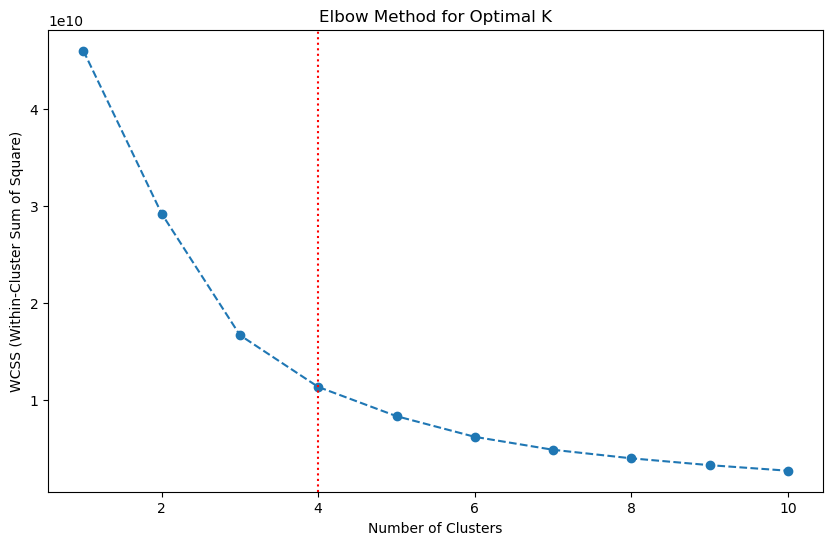

In [ ]:
# 可视化
plt.figure(figsize=(10,6))
plt.plot(range(1, max_clusters+1), wcss, marker='o', linestyle='--')
plt.xlabel('Number of Clusters')
plt.ylabel('WCSS (Within-Cluster Sum of Square)')
plt.title('Elbow Method for Optimal K')
plt.axvline(x=4, color='r', linestyle=':') 
plt.show()


In [ ]:
# 轮廓系数法（Silhouette Analysis）
silhouette_scores = []
for k in range(2, max_clusters+1):
    kmeans = KMeans(n_clusters=k, random_state=42)
    preds = kmeans.fit_predict(factor_scores)
    score = silhouette_score(factor_scores, preds)
    silhouette_scores.append(score)
